**<h3>Python Script Imports</h3>**

In [26]:
# Python Library imports
import os
import sys
import importlib    
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib

# Paths
housing_path = r"E:/Future Plans/Post-Graduation-Projects/Hands-on Machine Learning/first-project/datasets/housing.csv"
python_scripts_path = r"E:/Future Plans/Post-Graduation-Projects/Hands-on Machine Learning/first-project/python-scripts"
custom_transformers_path = r"E:/Future Plans/Post-Graduation-Projects/Hands-on Machine Learning/first-project/python-scripts/custom-transformers"
model_dumps_path = r"E:/Future Plans/Post-Graduation-Projects/Hands-on Machine Learning/first-project/model_dumps"

# Path initialization so that Python can see where our script lies.
script_dir = os.path.abspath(python_scripts_path) 
custom_transformers_script_dir = os.path.abspath(custom_transformers_path) 
sys.path.append(script_dir)
sys.path.append(custom_transformers_script_dir)
sys.path.append(model_dumps_path)

# Custom Python Script Imports
from sklearn.model_selection import StratifiedShuffleSplit
from test_set_check import test_set_check
from split_train_test_by_id import split_train_test_by_id
from load_housing_data import load_housing_data
from combined_attributes_adder import CombinedAttributesAdder
from data_frame_selector import DataFrameSelector
from display_scores import display_scores
# Loads housing data
housing = load_housing_data(housing_path)

**<h3>Data-preperation</h3>**
**<h5>Important</h3>**
- This is a continuation from the notebook titled: **II. Select and Train a Model**

In [27]:
#limits number of income categories
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5) 
#merge "larger than 5" categories into category 5
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=False) 
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

housing = strat_train_set.drop("median_house_value", axis=1) 
housing_labels = strat_train_set["median_house_value"].copy()

In [28]:
housing_num = housing.drop("ocean_proximity", axis=1) 
num_pipeline = Pipeline([
('imputer', SimpleImputer(strategy="median")),
('attribs_adder', CombinedAttributesAdder()),
('std_scaler', StandardScaler()),
])
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [29]:
num_attribs = list(housing_num)
print("num_attribs:" + str(num_attribs))
cat_attribs = ["ocean_proximity"]
num_pipeline = Pipeline([
('selector', DataFrameSelector(num_attribs)),
('imputer', SimpleImputer(strategy="median")),
('attribs_adder', CombinedAttributesAdder()),
('std_scaler', StandardScaler()),
])

num_attribs:['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'income_cat']


In [30]:
cat_pipeline = Pipeline([
('selector', DataFrameSelector(cat_attribs)),
('cat_encoder', OneHotEncoder(sparse_output=True)),
])

In [31]:
full_pipeline = FeatureUnion(transformer_list=[
("num_pipeline", num_pipeline),
("cat_pipeline", cat_pipeline),
])

housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared.shape

(16512, 17)

**<h3>Model fine-tuning - Grid Search</h3>**

**<h5>Idea</h5>**
- Adjust the hyper-parameters manually, until you find a good combo of hyper-parameters
- **Hyperparameter**:
  + A variable used to control the training process, before the training begins.
  + Think of it like a knob/switch adjusting the training process.
  + All we need is to find those knobs/switches.
  + We call it hyperparameter because: once we adjust those, it will affect the underneath model parameters. 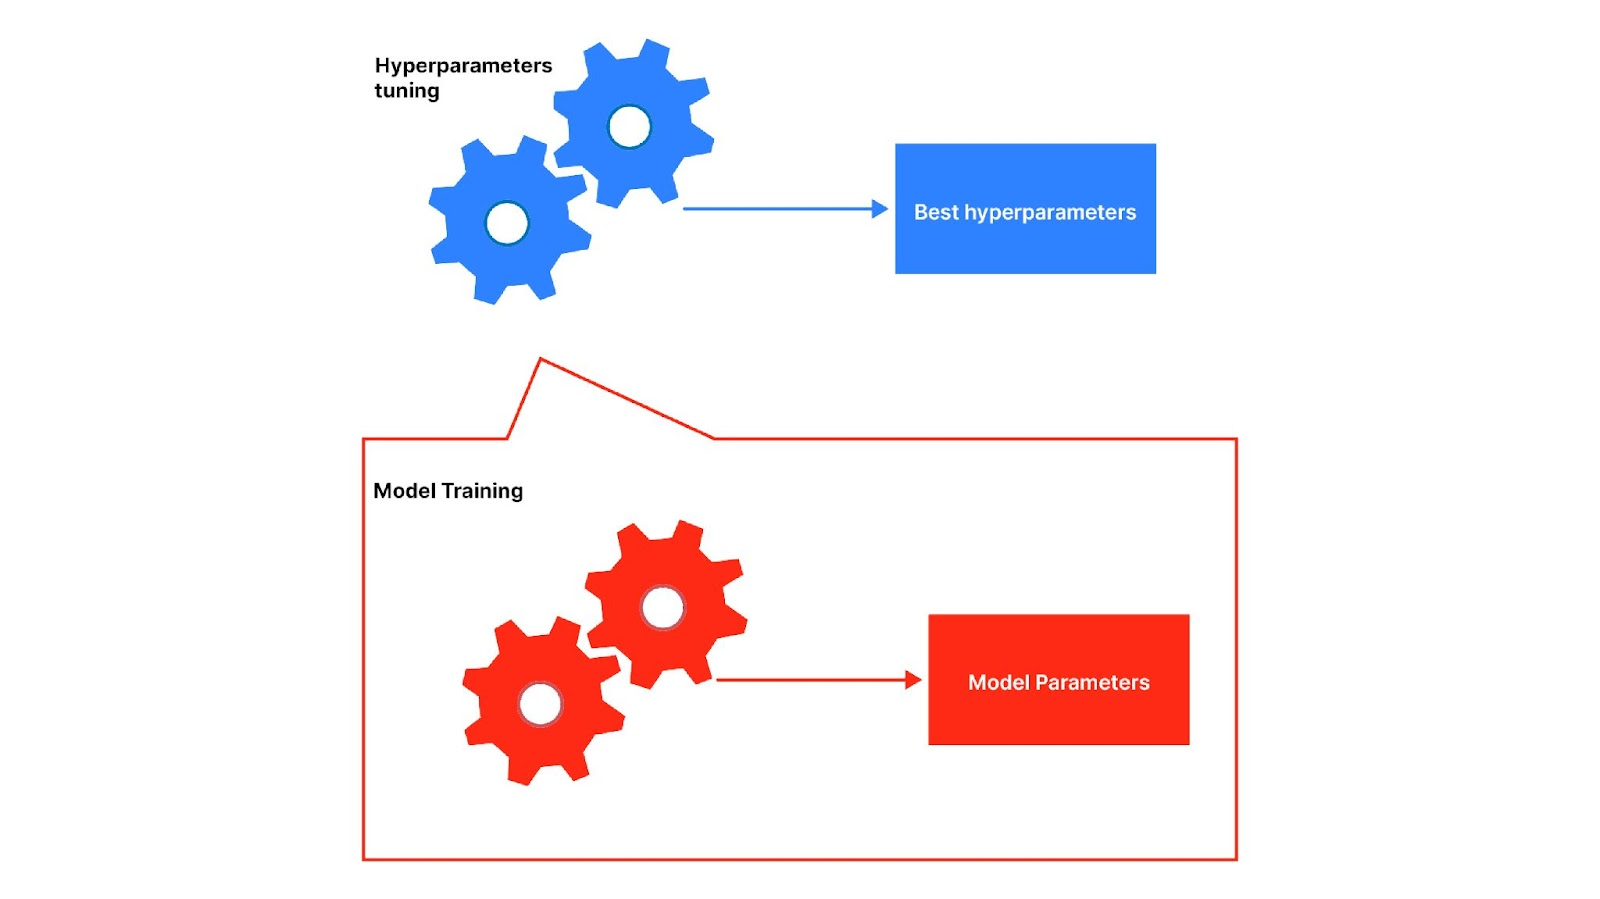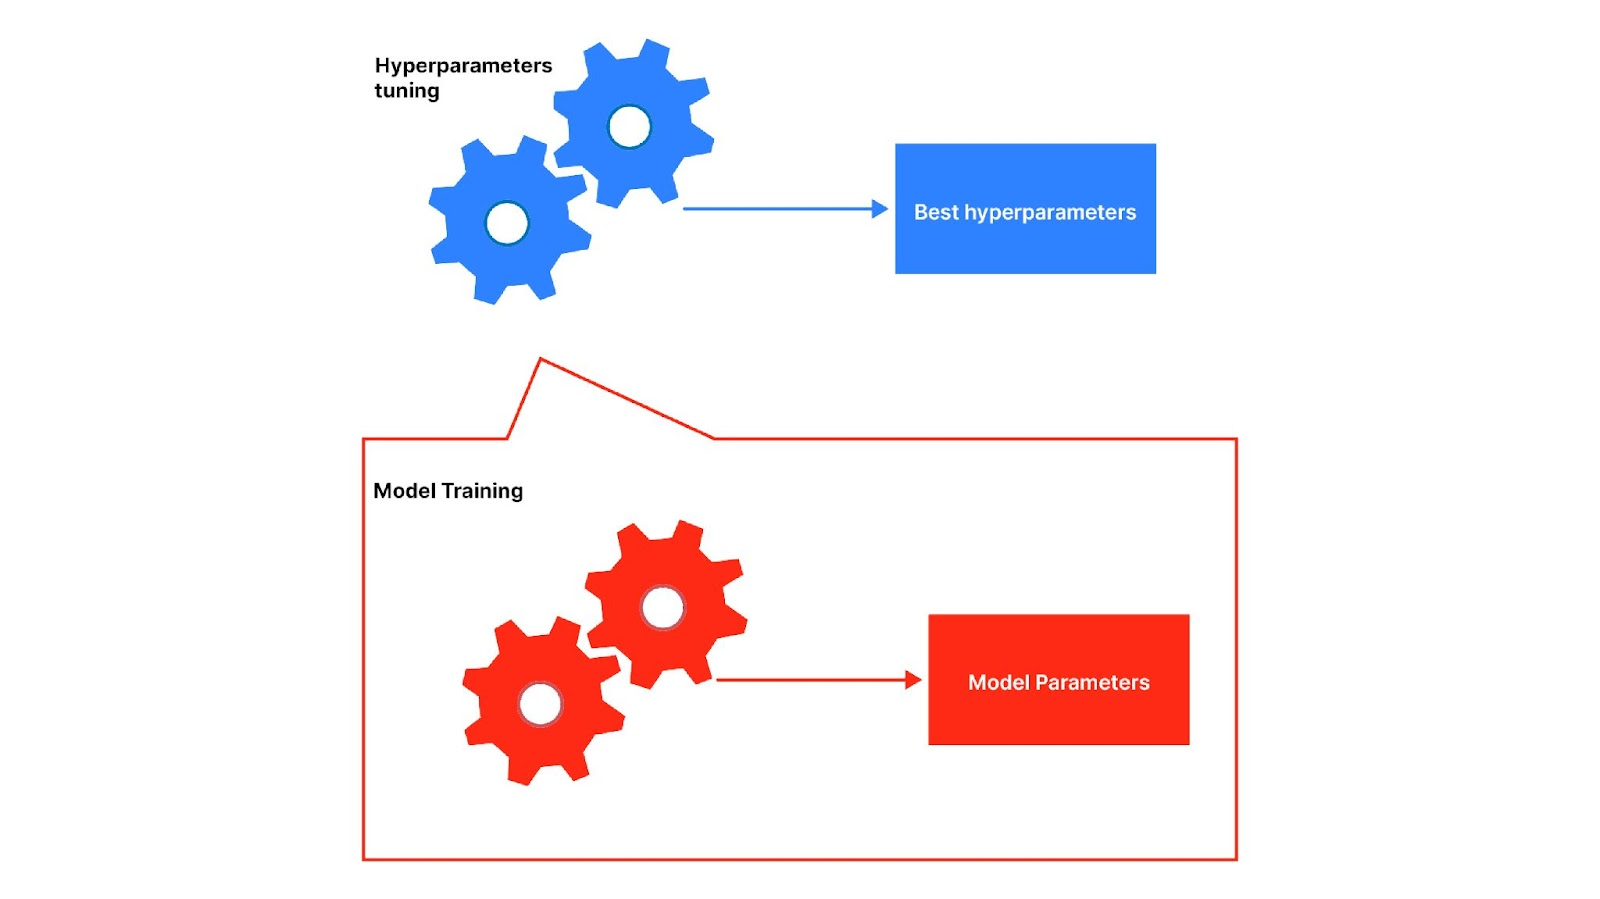

**<h5>Problem</h5>** 
- There are hundreds of hyper-parameters, how do we pick the best one?

**<h5>Solution</h5>**
- We tell GridSearchCV:
  + Hyper-parameters we want to experiment (e.g. **`n_estimators`**, **`max_features`**, **`bootstrap`**)
  + Values to try out (e.g. **`[3, 10, 30]`**, **`[2, 4, 6, 8]`**, **`[3, 10]`**)

In [34]:
param_grid = [
{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
{'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]
forest_reg = RandomForestRegressor(n_jobs=-1)
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
scoring='neg_mean_squared_error')
grid_search.fit(housing_prepared, housing_labels)
print("Grid search best params: "+ str(grid_search.best_params_))

Grid search best params: {'max_features': 8, 'n_estimators': 30}


**<h5> **`GridSearchCV`** Parameters </h5>**
- **`forest_reg`**: The Model to perform the Grid Search against.
- **`param_grid`**: A list of objects. Each object contains 2 attributes `n_estimators` and `max_features`.
- **`cv`**: Number of folds (subsets divided from the larger set)

**<h5> What **`GridSearchCV`** does </h5>**
- Take each value of the left object , and validate it against all values in the right object.
- 1st `n_estimators` example : 
  + 3 (`n_estimators`) vs (2, 4, 6, 8) (`max_features`) > 4 combinations
  + 10 (`n_estimators`) vs (2, 4, 6, 8) (`max_features`) > 4 combinations
  + 30 (`n_estimators`) vs (2, 4, 6, 8) (`max_features`) > 4 combinations
  + Total: 12 combinations.

- 2nd `n_estimators` example : 
  + 3 (`n_estimators`) vs (2, 3, 4) (`max_features`) > 3 combinations
  + 10 (`n_estimators`) vs (2, 3, 4) (`max_features`) > 3 combinations
  + Total: 6 combinations.

- Add 1st and 2nd examples: We have 12 + 6 = 18 combinations for 1 fold.
- Given 5 fold, we have **`12 * 5 = 90`** training rounds.


**<h3>Model fine-tuning - Randomized Search</h3>**

**<h5>Use Case</h5>**
- **Grid Search**: Used when the hyperparameter space is **small** 
- **Randomized Search**: Used when the hyperparameter space is **large**

**<h5>How it works</h5>**
- Instead of going through all combinations (like what we see above), for each hyperparameter:
  + Select random values instead of all values (e.g. 3 vs 4, 8 instead of 3 vs 2, 4, 6, 8)

**<h3>Model fine-tuning - Ensemble methods</h3>**

**<h5>Idea</h5>**
- Combine multiple best-performing models instead of using just 1 model

**<h3>Analyzing best Models</h3>**

**<h5>Idea</h5>**
- Focus on attributes (columns) that has high importance index. In other words:
  + If the important index is high > use that attribute for fine-tuning.
  + If the important index is low > discard it

**<h5>How-to</h5>**
- Use **`feature_importances()`** function from **`grid_search()`**

In [37]:
feature_importances = grid_search.best_estimator_.feature_importances_
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = cat_pipeline.named_steps["cat_encoder"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(np.float64(0.28425761325622595), 'median_income'),
 (np.float64(0.15316804926568564), 'income_cat'),
 (np.float64(0.11702462455208847), 'INLAND'),
 (np.float64(0.11178095199613829), 'pop_per_hhold'),
 (np.float64(0.06181803205523247), 'longitude'),
 (np.float64(0.05705495611258351), 'bedrooms_per_room'),
 (np.float64(0.05438006246834593), 'latitude'),
 (np.float64(0.04691742963997887), 'housing_median_age'),
 (np.float64(0.037344972118980364), 'rooms_per_hhold'),
 (np.float64(0.01622439505611875), 'total_rooms'),
 (np.float64(0.015652597329310847), 'population'),
 (np.float64(0.015163072771930575), 'total_bedrooms'),
 (np.float64(0.014364600564601001), 'households'),
 (np.float64(0.008191500653640825), '<1H OCEAN'),
 (np.float64(0.00403226556972387), 'NEAR OCEAN'),
 (np.float64(0.002539762133296913), 'NEAR BAY'),
 (np.float64(8.511445611766153e-05), 'ISLAND')]

**As we can see, median_income has the highest index, so we should focus on that for tweaking**